In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import gc
from functools import partial
import time
import pickle
from imp import reload
from os.path import join
from itertools import product

from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf

from data_loaders import Brats2015, Brats2017
import medim
from models_tf import EEnet, ModelController

%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
def compute_dices(y_pred, y_true):
    dices = []
    for yo_pred, yo_true in zip(y_pred, y_true):
        msegm_true = data_loader.segm2msegm(yo_true)
        msegm_pred = data_loader.segm2msegm(yo_pred)
        dices.append([medim.metrics.dice_score(msegm_pred[k], msegm_true[k])
                      for k in range(n_chans_msegm)])
    return np.mean(dices, axis=0)

In [4]:
brats2017 = True
brats2015 = not brats2017

if brats2017:
    processed_path = '/mount/export/brats2017/processed'
    data_loader = Brats2017(processed_path)
elif brats2015:
    processed_path = '/mount/export/brats2015/processed'
    data_loader = Brats2015(processed_path)
else:
    assert False

patients = data_loader.patients

spatial_size = data_loader.spatial_size
n_modalities = data_loader.n_modalities
n_chans_msegm = data_loader.n_chans_msegm
n_classes = data_loader.n_classes

x = []
y = []

for patient in tqdm(patients):
    x.append(data_loader.load_mscan(patient))
    y.append(data_loader.load_segm(patient))
    
n_modalities, n_chans_msegm, n_classes

(4, 3, 4)

In [7]:
metadata = data_loader.metadata

In [16]:
sd = ~metadata.survival.isnull().values

In [26]:
np.random.seed(17)

train = ~sd
val = ~train * (np.random.randint(2, size=len(patients), dtype=bool))
test = ~train & ~val 

train = np.argwhere(train)
val = np.argwhere(val)
test = np.argwhere(test)

In [31]:
len(train), len(val), len(test)

(122, 82, 81)

In [32]:
n_splits_train = 5
n_splits_val = 40

cv = KFold(n_splits_train, shuffle=True, random_state=42)
train, test = next(cv.split(y))

def extract(l, idx):
    return [l[i] for i in idx]

x_train, x_test = extract(x, train), extract(x, test)
y_train, y_test = extract(y, train), extract(y, test)

cv = KFold(n_splits_val, shuffle=True, random_state=21)
train, val = next(cv.split(x_train))

x_train, x_val = extract(x_train, train), extract(x_train, val)
y_train, y_val = extract(y_train, train), extract(y_train, val)

In [6]:
kernel_size = 3
blocks = [n_modalities, 32, 32, 64, 64]

patch_size_x = np.array([25, 25, 25])
patch_size_y = patch_size_x - 2*(len(blocks) - 1)*(kernel_size//2)

In [6]:
%%time

padding = (patch_size_x - patch_size_y) // 2

def min_padding(x, padding):
    # 3-dimentional spatial
    non_spatial = x.ndim - 3
    padding = np.array(padding)
    
    padding = list(zip(padding, padding))
    padding = [(0, 0)] * non_spatial + padding
    
    return np.pad(x, padding, mode='constant')

x_val_padded = [min_padding(s, padding) for s in x_val]
y_val_padded = np.array(y_val, dtype=int)

CPU times: user 484 ms, sys: 5.64 s, total: 6.13 s
Wall time: 6.13 s


In [7]:
patch_size_x, patch_size_y

(array([25, 25, 25]), array([17, 17, 17]))

In [8]:
log_path = '/tmp/tf'

restore_ckpt_path = None#'./checkpoints/ee-net'

tf.reset_default_graph()
model = EEnet(blocks, n_classes, kernel_size)
model_controller = ModelController(model, log_path, restore_ckpt_path)

In [60]:
lr = 0.005
batch_size = 128

n_epoch = 100
n_batches_per_epoch = 100

def cond(y):
    return y > 0

train_iter = medim.batch_iter.patch.foreground(
        [x_train, y_train], [patch_size_x, patch_size_y], batch_size=batch_size,
        spatial_dims=(-3, -2, -1), f_fraction=0.5, f_condition=cond
)

for epoch in range(n_epoch):
    gc.collect()
    print('Epoch {}'.format(epoch), flush=True)
    
    train_loss = model_controller.train(train_iter, lr, n_batches_per_epoch)
    print('Train:', train_loss, flush=True)
    
    y_pred, val_loss = model_controller.validate([x_val_padded], y_val_padded)
    print('Val       :', val_loss)
    
    val_dices = compute_dices(y_pred, y_val_padded)
    print('Val dices :', val_dices)
    
    print('\n', flush=True)

Epoch 0
Train: 0.243676
Val       : 0.0450319
Val dices : [ 0.84304292  0.6453008   0.54710687]


Epoch 1
Train: 0.245884
Val       : 0.0447903
Val dices : [ 0.84488904  0.662118    0.5464209 ]


Epoch 2
Train: 0.241086
Val       : 0.043301
Val dices : [ 0.85155596  0.65906593  0.54886376]


Epoch 3
Train: 0.241942
Val       : 0.0452771
Val dices : [ 0.84464561  0.65292923  0.54922676]


Epoch 4
Train: 0.240606
Val       : 0.0437766
Val dices : [ 0.84739051  0.65183082  0.54675475]


Epoch 5
Train: 0.242376
Val       : 0.0475553
Val dices : [ 0.83605087  0.66830167  0.54247785]


Epoch 6
Train: 0.24294
Val       : 0.0444783
Val dices : [ 0.84590839  0.65952622  0.5488746 ]


Epoch 7
Train: 0.240569
Val       : 0.0452962
Val dices : [ 0.84431334  0.65710744  0.54614743]


Epoch 8
Train: 0.242939
Val       : 0.0436333
Val dices : [ 0.84841697  0.67372025  0.54851209]


Epoch 9
Train: 0.244455
Val       : 0.0439496
Val dices : [ 0.84981665  0.63685949  0.54861007]


Epoch 10
Train: 0.2410

KeyboardInterrupt: 

In [61]:
s = tf.train.Saver()

In [63]:
print(np.newaxis)

None


In [ ]:
s.save(model_controller.session, )

In [15]:
train_iter = medim.batch_iter.patch.foreground(
        [x_train, y_train], [patch_size_x, patch_size_y], batch_size=batch_size,
        spatial_dims=(-3, -2, -1), f_fraction=0.5, f_condition=cond
    )

x_batch, y_batch = next(iter(train_iter))

In [ ]:
import imp
imp.reload(medim.batch_iter.patch.foreground)

In [30]:
y_pred_proba = model_controller.predict_proba(
    tqdm(map(partial(min_padding, padding=padding), x_test)))

KeyboardInterrupt: 

In [36]:
y_val[0].shape

(157, 189, 149)

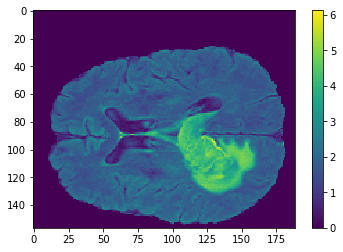

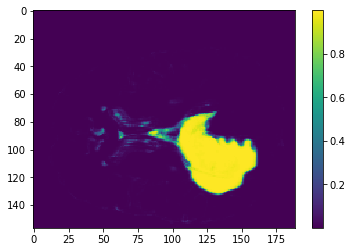

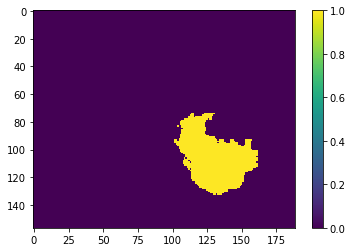

In [48]:
m = 81
k = 0

plt.imshow(x_val[0][3, ..., m])
plt.colorbar()
plt.show()
plt.imshow(msegms[0][k, ..., m])
plt.colorbar() 
plt.show()
plt.imshow(y_val[0][..., m] > 0)
plt.colorbar()
plt.show()

In [26]:
y_pred_proba = model_controller.predict_proba([x_val_padded])

In [12]:
compute_dices(y_pred, y_val_padded)

array([ 0.80115887,  0.57093293,  0.76356091])

In [51]:
def sum_probs(yo_pred_proba):
    msegm = np.zeros((3, *yo_pred_proba.shape[1:]))
    msegm[0] = yo_pred_proba[1:].sum(axis=0)
    msegm[1] = yo_pred_proba[[1, 3]].sum(axis=0)
    msegm[2] = yo_pred_proba[3]
    return msegm

msegms = [sum_probs(y) for y in y_pred_proba]
msegms_true = [data_loader.segm2msegm(y) for y in y_val]

In [53]:
def get_dice_threshold(msegms, msegms_true):
    thresholds = []
    for i in range(n_chans_msegm):
        ps = np.linspace(0, 1, 20)
        best_p = 0
        best_score = 0
        for p in ps:
            score = np.mean([medim.metrics.dice_score(pred[i] > p, true[i])
                             for pred, true in zip(msegms, msegms_true)], axis=0)
            if score is np.nan or None:
                print('None')
                score = 1
            
            if score > best_score:
                best_p = p
                best_score = score
        thresholds.append(best_p)
        print(best_score)
    return thresholds

thresholds = get_dice_threshold(msegms, msegms_true)
thresholds

0.868340979672
0.684483748825
0.557899718218


[0.78947368421052633, 0.36842105263157893, 0.63157894736842102]

In [55]:
gc.collect()

0

In [59]:
y_pred_proba = []

for xo_test, yo_test in tqdm(zip(x_test, y_test)):
    mscan = min_padding(xo_test, padding)
    #msegm = np.array(msegm, dtype=np.float32)

    #mscan_parts = medim.utils.divide(mscan, padding, n_parts)
    #msegm_parts = medim.utils.divide(msegm, [0, 0, 0], n_parts)

    predicted = []
    
    #o = np.array(mscan_part[None, :])
    gc.collect()
    y_pred_proba.append(model_controller.predict_proba([xo_test[None, :]])[0])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [ ]:
np.mean([[dice_score(y_preds_t[i][k] > thresholds[k], y_test[i][k]) for k in range(n_classes)]
         for i in range(len(y_preds_t))], axis=0)

In [ ]:
len(x_train), len(x_val), len(x_test)

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))

i = 4
k = 90

cmap = cm.GnBu
fontsize = 30

ax[0, 0].set_title('Predicted segmentation', fontsize=fontsize)
ax[0, 0].imshow(y_preds_t[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].set_title('Ground truth', fontsize=fontsize)
ax[0, 1].imshow(y_test[i][0, ..., k], cmap=cmap)

ax[1,0].set_title('Brain slice', fontsize=fontsize)
ax[1, 0].imshow(x_test[i][3, ..., k], cmap=cmap)
plt.tight_layout()
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 1].axis('off')
plt.show()
#plt.colorbar()
#plt.show()

In [10]:
def segm_log_loss(yo_pred, yo_true):
    y_pred = np.moveaxis(yo_pred, 0, 3).reshape((-1, n_classes))
    y_true = yo_true.flatten()
    return log_loss(y_true, y_pred)

In [ ]:
# def pred_reshape(y):
#     x = y.permute(0, 2, 3, 4, 1)
#     return x.contiguous().view(-1, x.size()[-1])

# def loss_cross_entropy(y_pred, y_true):
#     return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))


coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)

In [ ]:
def predict_object(model, xo, n_parts_per_axis):
    model.eval()
    xo_parts = medim.utils.divide(xo, [0] + [*padding], n_parts_per_axis)

    xo_predicted = []
    for xo_part in xo_parts:
        xo_part = xo_part[None, :]

        y_pred = model(to_var(xo_part, volatile=True))

        xo_predicted.append(to_numpy(y_pred)[0])

    yo_pred = medim.utils.combine(xo_predicted, n_parts_per_axis)
    return yo_pred